In [1]:
# Numpy for working with Arrays
import numpy as np

# Pandas for working with data tables
import pandas as pd

# SciPy implements many different numerical algorithms
import scipy as sp
import scipy.stats as stats
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import hstack

# Module for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from cycler import cycler

# scikit learn packages
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


C:\Anaconda2\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
### load data from csv files
water_values = pd.read_csv('./data/train_set_values.csv')
water_labels = pd.read_csv('./data/train_set_labels.csv')

# list categorical features to be turned into dummy variables:
cat_features = ['id', 'region_code', 'district_code', 'basin', 'region', 'public_meeting', \
                'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', \
                'management', 'water_quality', 'quantity', \
                'source', 'waterpoint_type', 'recorded_by', 'funder', 'installer', \
               'lga', 'ward', 'scheme_name', 'management_group', 'subvillage', 'wpt_name', \
               'payment_type', 'source_class', 'payment', 'extraction_type_group', 'quality_group', \
                'quantity_group', 'source_type', 'waterpoint_type_group']

# list numeric features
num_features = ['id', 'gps_height', 'longitude', 'latitude', 'amount_tsh', 'num_private', 'construction_year' \
                , 'population', 'date_recorded']

# make dataframe of just the categorical features, use id as index
water_cat = water_values.loc[:,cat_features].set_index('id')

# make dataframe of just numeric (basically, the rest of the columns), use id as index
water_num = water_values.loc[:,num_features].set_index('id')


# prepare test data for model prediction
test = pd.read_csv('./test_set_values.csv')

# make dataframe of just the categorical features, use id as index
test_cat = test.loc[:,cat_features].set_index('id')

# make dataframe of just numeric (basically, the rest of the columns), use id as index
test_num = test.loc[:,num_features].set_index('id')

# remove categorical values that occur fewer than threshold
threshold = 2 # Anything that occurs less than this will be removed.
for col in water_cat:
    vc = water_cat[col].value_counts()
    vals_to_remove = vc[vc < threshold].index.values
    water_cat.loc[water_cat[col].isin(vals_to_remove), col] = None

    
# impute 'missing' for categorical NaNs 
for dataset in [water_cat, test_cat]:
    for col in dataset:
        idx = dataset.loc[:,col][dataset[col].isnull() == True].index
        dataset.set_value(idx, col, 'missing')
        idx = dataset.loc[:,col][dataset[col] == 0].index
        dataset.set_value(idx, col, 'missing')


imp_water = pd.read_csv('water_num_imputed.csv')
imp_test = pd.read_csv('test_num_imputed.csv')

for col in water_num:
    if col in ['gps_height', 'longitude', 'latitude', 'construction_year']:
        water_num.loc[water_num[col] == 0, col] = imp_water[col]

for col in test_num:
    if col in ['gps_height', 'longitude', 'latitude', 'construction_year']:
        test_num.loc[test_num[col] == 0, col] = imp_test[col]
        
        

# convert status labels to numeric
water_labels['status_group'] = water_labels.status_group.factorize()[0]


# replace 0s with NaN in columns where 0 likely doesn't mean 'zero'
for dataset in [water_num, test_num]:
    for col in ['population', 'construction_year','num_private', 'longitude']:
        dataset[col].replace(0, np.nan, inplace = True)

# removed: , 'amount_tsh', 'gps_height'

# transform date to float
for dataset in [water_num, test_num]:
    dataset['date_recorded'] = pd.to_datetime(dataset['date_recorded'])
    dataset['month'] = dataset['date_recorded'].dt.month
    dataset['year'] = dataset['date_recorded'].dt.year
    dataset['date_recorded'] = (dataset['date_recorded'] - dataset['date_recorded'].min())  / np.timedelta64(1,'D')


# preprocessing steps

# encode labels to floats
le = preprocessing.LabelEncoder()

# labels to floats, row by row (le doesn't work across df's)
for col in water_cat:
    le.fit(water_cat[col].append(test_cat[col]))
    water_cat.loc[:,col] = le.transform(water_cat.loc[:,col])
    test_cat.loc[:,col] = le.transform(test_cat.loc[:,col])

# same for test:
#for col in test_cat:
#    encoded = le.transform(test_cat.loc[:,col])
#    test_cat.loc[:,col] = encoded

# preprocessing steps

# encode labels to floats
le = preprocessing.LabelEncoder()

# labels to floats, row by row (le doesn't work across entire df's)
for col in water_cat:
    le.fit(water_cat[col].append(test_cat[col]))
    water_cat.loc[:,col] = le.transform(water_cat.loc[:,col])
    test_cat.loc[:,col] = le.transform(test_cat.loc[:,col])

# same for test:
#for col in test_cat:
#    encoded = le.transform(test_cat.loc[:,col])
#    test_cat.loc[:,col] = encoded

# define one hot encoder (for dummy variables)
enc = preprocessing.OneHotEncoder(handle_unknown = 'ignore')

# make dummy variables
water_cat = enc.fit_transform(water_cat)

# fit test data to same dummies
test_cat = enc.transform(test_cat)

# impute data
imp = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0, verbose=0, copy=True)
water_num = imp.fit_transform(water_num)

# transform test
test_num = imp.transform(test_num)


# standardize numeric variables
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1), copy=True)
water_num = minmax_scale.fit_transform(water_num)

# transform test
test_num = minmax_scale.transform(test_num)


print 'water_cat shape: %s' % (str(water_cat.shape))
print 'test_cat shape: %s' % (str(test_cat.shape))
print 'water_num shape: %s' % (str(water_num.shape))
print 'test_num shape: %s' % (str(test_num.shape))



# set to float32 (from float64) to conserve memory

water_cat = sp.sparse.csr_matrix(water_cat, dtype = 'float32')
test_cat = sp.sparse.csr_matrix(test_cat, dtype = 'float32')
water_num = sp.sparse.csr_matrix(water_num, dtype = 'float32')
test_num = sp.sparse.csr_matrix(test_num, dtype = 'float32')


### prepare variables for model fitting

# convert to sparse matrix
water_num = csr_matrix(water_num)

# concatenate 
X = hstack([water_num, water_cat])
Xtest = hstack([test_num, test_cat]) # capital Xtest = real test set for submission

# flatten label column into a 1-D array called y
y = np.ravel(water_labels['status_group'])

# split into training/test sets for crossval
xtrain, xtest, ytrain, ytest = \
cross_validation.train_test_split(X, y, test_size=0.2, random_state=12345)

### create DF to hold predictions for training ensemble
ens_df = pd.DataFrame()

### create DF to hold predictions for final test submission
pred_df = pd.DataFrame()

### prepare for ROC curves
# binarize labels
y_test = label_binarize(ytest, classes = [0,1,2])


water_cat shape: (59400, 20702)
test_cat shape: (14850, 20702)
water_num shape: (59400L, 10L)
test_num shape: (14850L, 10L)


In [3]:
##### Model building #####

Logistic Regression test score: 0.787795


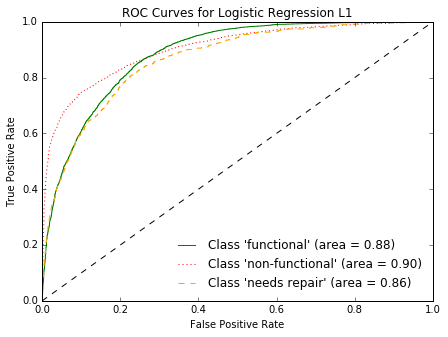

In [4]:
### Logistic Regression Classifier
# instantiate a logistic regression model, and fit with train
clf_lr = LogisticRegression(penalty = 'l1', C = 1)
clf_lr = clf_lr.fit(xtrain, ytrain)
print 'Logistic Regression test score: %f' % (clf_lr.score(xtest,ytest))

# run prediction on test
yhat_log_test = clf_lr.predict(xtest)

# run probability prediction to df (for ROC)
yhat_lr_proba_test = clf_lr.predict_proba(xtest)

# add prediction to ensemble df
ens_df['lr'] = yhat_log_test


### ROC curve
# get number of classes
n_classes = yhat_lr_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_lr_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression L1')
plt.legend(loc="lower right", frameon=False)
plt.savefig('ROC_lr.png',bbox_inches='tight')

Random Forest test score: 0.810017


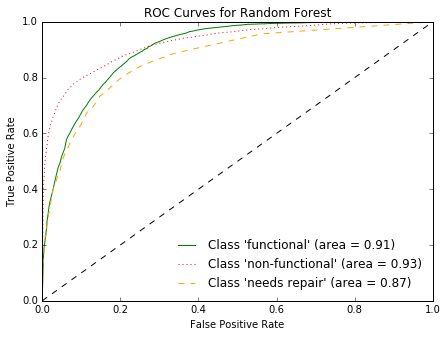

In [5]:
### Random Forest Classifier
# instantiate a ### Random Forest Classifiern model, and fit with train
clf_rf = RandomForestClassifier(n_estimators=100)

# fit model on training
clf_rf.fit(xtrain, ytrain)

print 'Random Forest test score: %f' % (clf_rf.score(xtest, ytest))

# run prediction on test
yhat_rf_test = clf_rf.predict(xtest)

# run probability prediction to df (for ROC)
yhat_rf_proba_test = clf_rf.predict_proba(xtest)

# add prediction to ensemble df
ens_df['rf'] = yhat_rf_test


### ROC curve
# get number of classes
n_classes = yhat_rf_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_rf_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest')
plt.legend(loc="lower right", frameon=False)
plt.savefig('ROC_rf.png',bbox_inches='tight')

Decision Tree test score: 0.787626


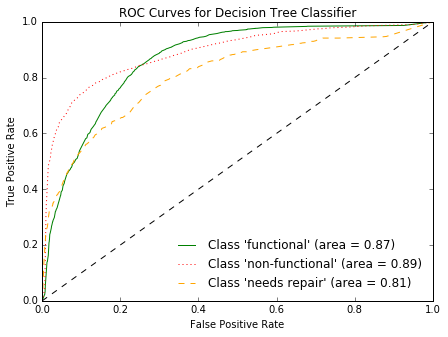

In [6]:
### Decision Tree Classifier
# define  classifier
clf_dt = DecisionTreeClassifier(max_features = None, criterion = 'gini', min_samples_leaf = 1, max_leaf_nodes = 1000)
# fit model on training
clf_dt.fit(xtrain, ytrain)

# check accuracy on test set
print 'Decision Tree test score: %f' % (clf_dt.score(xtest, ytest))

# run prediction on train
yhat_dt_test = clf_dt.predict(xtest)

# run probability prediction to df (for ROC)
yhat_dt_proba_test = clf_dt.predict_proba(xtest)

# add prediction to ensemble df
ens_df['dt'] = yhat_dt_test

#Decision Tree test score: 0.789226

### ROC curve
# get number of classes
n_classes = yhat_dt_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_dt_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Classifier')
plt.legend(loc="lower right", frameon=False)

plt.savefig('ROC_dt.png',bbox_inches='tight')

In [7]:
# check correlation of ensemble inputs
ens_df.apply(lambda s: ens_df.corrwith(s))

,lr,rf,dt
lr,1.000000,0.688147,0.674500
rf,0.688147,1.000000,0.678632
dt,0.674500,0.678632,1.000000


[ 0.79471033  0.78002528  0.82427307]
0.799669561322


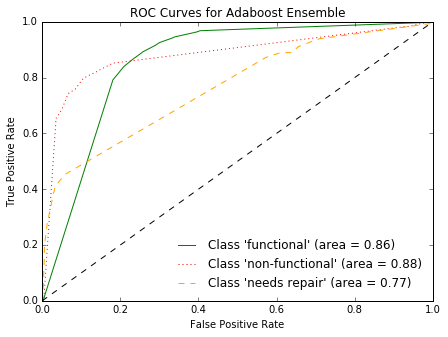

In [8]:
### Adaboost ensemble classifier

# convert dataframe to array
ens_array = ens_df.as_matrix()

# split ens_array into training/test sets for ada crossval
x_ens_train, x_ens_test, y_ens_train, y_ens_test = \
cross_validation.train_test_split(ens_array, ytest, test_size=0.2, random_state=12345)

# define model

ada = AdaBoostClassifier(DecisionTreeClassifier(max_features = None, criterion = 'gini'))

# fit adaboost
ada.fit(x_ens_train, y_ens_train)

scores = cross_validation.cross_val_score(ada,
        x_ens_test, y_ens_test)

# run probability prediction to df (for ROC)
yhat_ada_proba_test = ada.predict_proba(x_ens_test)

# here's what we do: train LR, RF, DT on train. predict on test set. train adaboost on test predictions. then train LR, RF, DT on full. 
# predict on TEST w/ all 3. predict adaboost on TEST

print scores

print scores.mean()
### where we've left it: 4 classifiers trained, ada ensemb = 80.2. Worth doing full dataset train below?

### ROC curve -- ensemble
# get number of classes

# re-binarize label for ensemble
y_test = label_binarize(y_ens_test, classes = [0,1,2])

n_classes = yhat_ada_proba_test[1]
classes = ['functional', 'non-functional', 'needs repair']

# create dicts to hold false positives, true positives, areas under curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# calculate curves
for i in range(len(n_classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], yhat_ada_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))

# set colors
plt.rc('axes', prop_cycle=(cycler('color', ['g', 'r', 'orange']) +
                           cycler('linestyle', ['-', ':', '--'])))

# build plot lines for each class
for i in range(len(n_classes)):
    plt.plot(fpr[i], tpr[i], label='Class \'{0}\' (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--') # dotted diagonal line
plt.xlim([0.0, 1.0]) # axis limits
plt.ylim([0.0, 1.0]) # axis limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Adaboost Ensemble')
plt.legend(loc="lower right", frameon=False)

plt.savefig('ROC_ada.png',bbox_inches='tight')

In [9]:
#### Make predictions on final dataset for submission

# train LR model on full dataset
clf_lr = clf_lr.fit(X, y)

# run prediction on FINAL TEST data
yhat_log_pred = clf_lr.predict(Xtest)

# add prediction to ensemble df
pred_df['lr'] = yhat_log_pred

# fit RF model on full dataset
clf_rf.fit(X, y)

# run prediction on FINAL TEST data
yhat_rf_pred = clf_rf.predict(Xtest)

# add prediction to ensemble df
pred_df['rf'] = yhat_rf_pred

# fit DT model on full dataset
clf_dt.fit(X, y)

# run prediction on FINAL TEST data
yhat_dt_pred = clf_dt.predict(Xtest)

# add prediction to ensemble df
pred_df['dt'] = yhat_dt_pred

# convert dataframe to array
pred_array = pred_df.as_matrix()

### Adaboost Ensemble: FINAL predictions

# fit adaboost on full training set (earlier was only on training split of test set)
ada.fit(ens_array, ytest)

# make final ensemble predictions
predictions = ada.predict(pred_array)

# create submission file

test['status_group'] = predictions
map_dict = {0: 'functional', 1: 'non functional', 2: 'functional needs repair'}
test['status_group'] = test['status_group'].map(map_dict)
test_submit = test[['id', 'status_group']]
test_submit.to_csv('submit_lr_fr_dt__ada_20160528b_impute_lasso_thresh2.csv', index = False)